In [331]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import SCORERS
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
load_dotenv()
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [291]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append('../src')

from data import make_dataset

%aimport data.make_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [313]:
model_data = make_dataset.run(
    collection='climate_submissions',
    media_tags=[
        'tag_technorati_uspolitics_20100709',
        'tag_none',
        'tag_print_native',
        'tag_national',
        'tag_geo_USA',
        'tag_en',
        'tag_United States'
    ],
    entities=[
        'Misinformation',
        'Sweden',
        'Photograph',
        'Property',
        'Tourism',
        'Sustainable development',
    ],
    topics=[
        'Culture',
        'Technology',
        'Belief',
        'Violence',
        'Politics',
        'Science',
        'Nature',
        'Law',
        'Business',
        'Arts',
        'Health',
    ],
    preceeding_activity_minutes=30
)

done with fetching


../src/data/make_dataset.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_action='ignore')
../src/data/make_dataset.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_action='ignore')


done making other data sets


In [319]:
baseline_df = model_data.dropna(subset=['fb_interactions'])

# Plan

Model: Random Forest

Features:
    - hour bucket
    - day of week categorical
    - tone score
    - sentiment
    - facebook comments
    - length of article
    
Dep Var:
    - Number of comments
    - score

# EDA

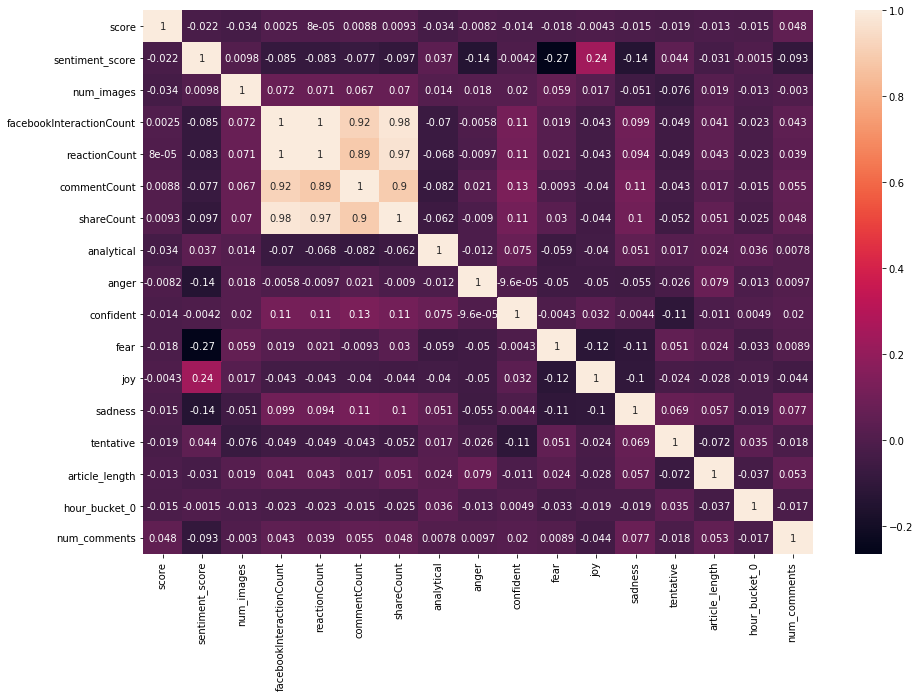

In [389]:
plt.figure(figsize=(15, 10))
sns.heatmap(baseline_df[list(baseline_df.columns[3:24]) + ['num_comments']].corr(), annot=True)

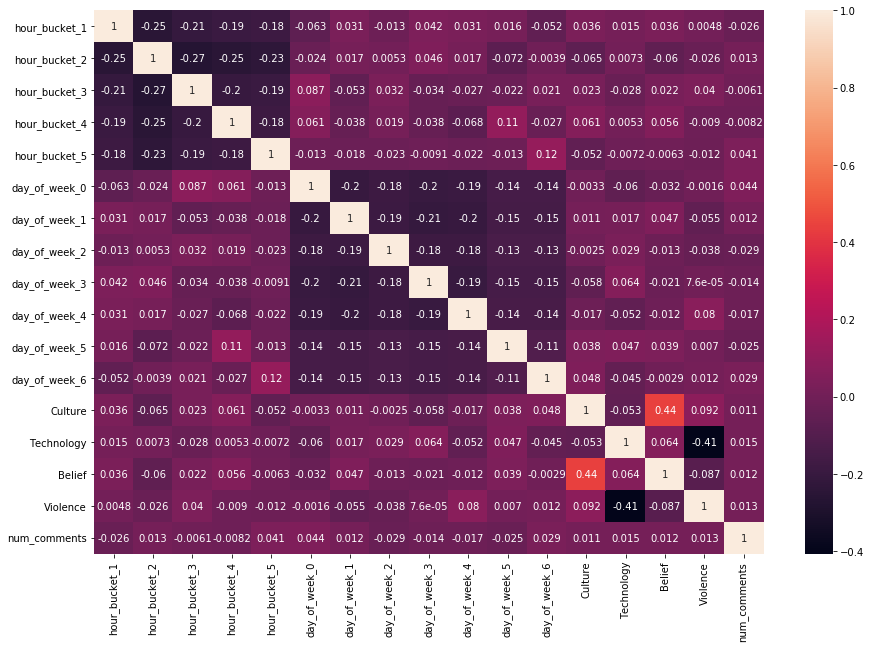

In [390]:
plt.figure(figsize=(15, 10))
sns.heatmap(baseline_df[list(baseline_df.columns[24:40]) + ['num_comments']].corr(), annot=True)

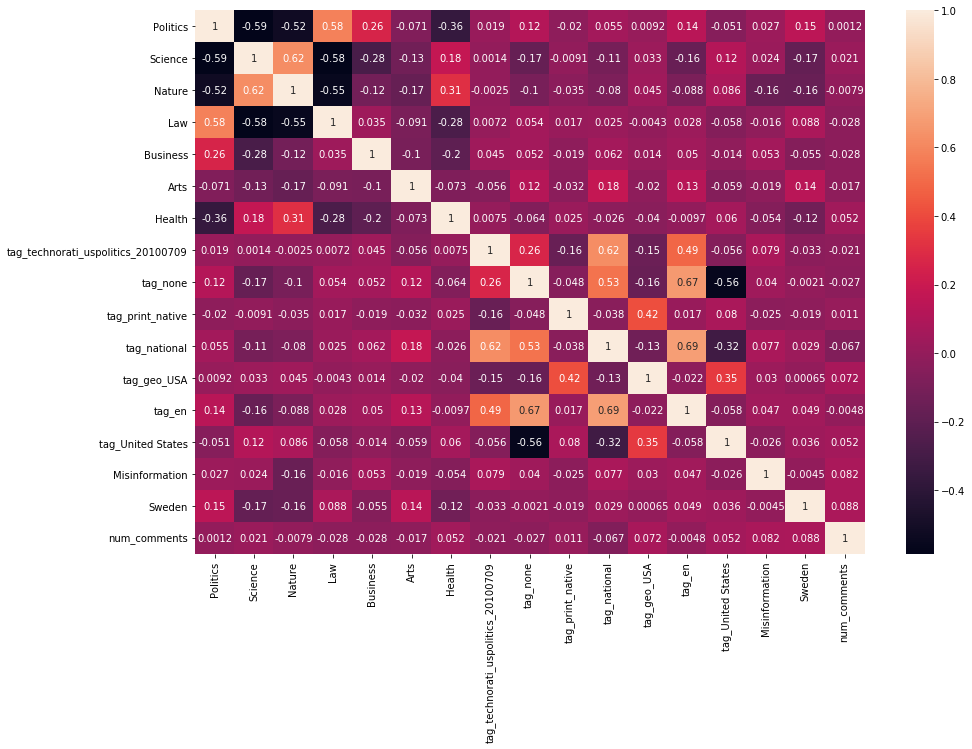

In [393]:
plt.figure(figsize=(15, 10))
sns.heatmap(baseline_df[list(baseline_df.columns[40:56]) + ['num_comments']].corr(), annot=True)

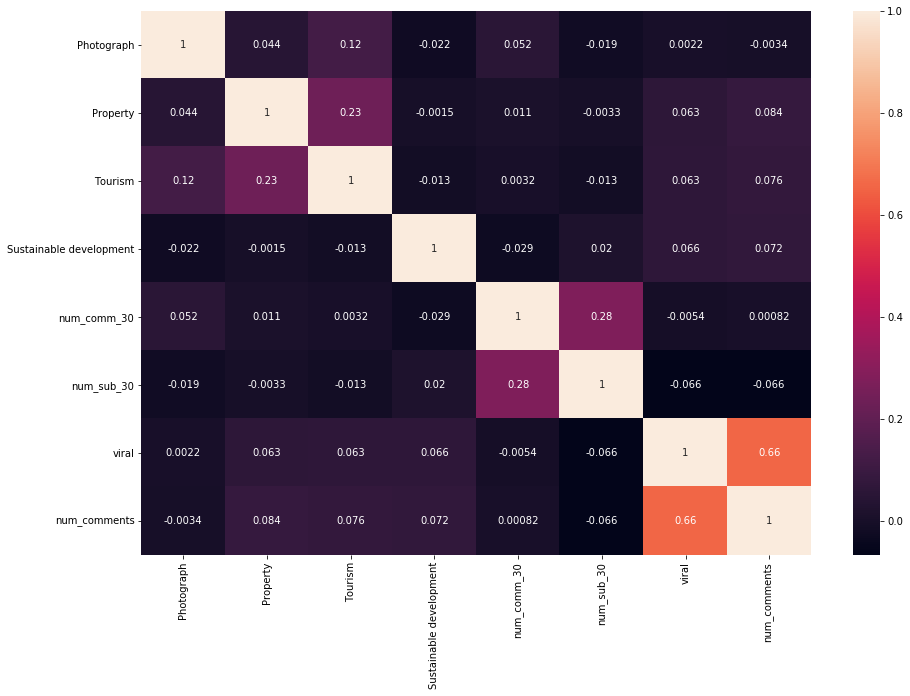

In [394]:
plt.figure(figsize=(15, 10))
sns.heatmap(baseline_df[list(baseline_df.columns[56:]) + ['num_comments']].corr(), annot=True)

# Baseline Model

In [ ]:
baseline_df = baseline_df.fillna(0)

## Classification

In [346]:
X_class, y_class = baseline_df.drop(columns=[
    'created_utc',
    'text',
    'num_comments',
    'score',
    'url',
    '_id',
    'tones',
    'fb_interactions',
    'post_date',
    'viral'
]), baseline_df.viral
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42)

In [347]:
cv_res = cross_validate(
    RandomForestClassifier(
        random_state=42,
        max_depth=3,
        n_estimators=100
    ),
    X_train_cl,
    y_train_cl,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#     scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    scoring=['precision', 'recall'],
    return_train_score=True,
    return_estimator=True
)

/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/willyraedy/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

In [349]:
# algorithm is never predicting a viral article

In [348]:
cv_res

{'fit_time': array([0.18783903, 0.15677905, 0.21083522, 0.176929  , 0.22127724]),
 'score_time': array([0.02305198, 0.03153801, 0.0382998 , 0.02334523, 0.02900887]),
 'estimator': (RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=3, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=100,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False),
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=3, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                   

## Regression

In [351]:
X_reg, y_reg = baseline_df.drop(columns=[
    'created_utc',
    'text',
    'num_comments',
    'score',
    'url',
    '_id',
    'tones',
    'fb_interactions',
    'post_date',
    'viral'
]), baseline_df.num_comments
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

In [356]:
cv_res = cross_validate(
    RandomForestRegressor(
        random_state=42,
        max_depth=5,
        n_estimators=100
    ),
    X_train_reg,
    y_train_reg,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    return_train_score=True,
    return_estimator=True
)

In [357]:
cv_res

{'fit_time': array([0.35094881, 0.35490203, 0.34803391, 0.31707907, 0.30860496]),
 'score_time': array([0.01576233, 0.02023602, 0.01646113, 0.01669407, 0.0154109 ]),
 'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                        max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100

**things to try**

- Look at Austin's data
- Get reddit data from crowd tangle
- Fix bad data (length of article and maybe others)
- Try different subreddit
- Learn more about reddit visibility
- Brainstorm other predictors
- Try PCA
- Feature Engineering:
    - Comments/Post in last 30 min
- Try different models
    - GLM with gaussian
- Run grid search on models
- Try anomaly detection
- Drastically simplify
- Look at popular articles and see if you